# Postsynaptic currents

The WSLFP method depends on the shape of the postsynaptic current (PSC) induced by each spikes.
Here we look at two commonly used functions to fit PSCs: the alpha function and the biexponential function.
These can be used with current-based or conductance-based models, but we will focus on the former.

For more details, see [Jochen Braun's theoretical neuroscience lecture notes](https://bernstein-network.de/wp-content/uploads/2021/02/06_Lecture-06-Synaptic-conductances.pdf) or Dayan and Abbott's Theoretical Neuroscience, p. 180.
For implementation details in Brian, see their [documentation](https://brian2.readthedocs.io/en/stable/introduction/brian1_to_2/library.html#synapses).

Below we will see that we can compute PSCs from spikes directly from spike times rather than simulating them as part of the differential equations of the network model.
This allows us to compute the WSLFP proxy without simulating expensive synaptic dynamics.
The `wslfp` package provides the `WSLFP.compute_from_spikes()` function to facilitate this.

In [18]:
import brian2.only as b2
import numpy as np
import matplotlib.pyplot as plt

## Alpha post-synaptic currents
This can be described as
$$P_\alpha(t) = P_\text{max} \frac{t}{\tau} \exp\left(1 - \frac{t}{\tau}\right), \quad t \geq 0$$
where $\tau$ is the time constant of the PSC.

INFO       No numerical integration method specified for group 'synapses_1', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


[Text(0.5, 1.0, 's'), Text(0.5, 0, 'time (ms)'), []]

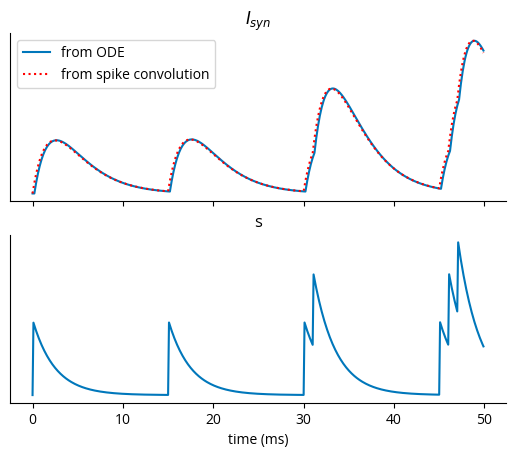

In [19]:
b2.prefs.codegen.target = "numpy"
ng = b2.NeuronGroup(
    1,
    """dv/dt = (I_syn - v)/ms : 1
    I_syn : 1""",
)
t_spk = [0, 15, 30, 31, 45, 46, 47] * b2.ms
sgg = b2.SpikeGeneratorGroup(
    1,
    np.zeros(len(t_spk)),
    t_spk,
)
# alpha current synapse
tau_syn = 2.5 * b2.ms
syn = b2.Synapses(
    sgg,
    ng,
    """dI_syn_syn/dt = (s - I_syn)/tau_syn : 1
    I_syn_post = I_syn_syn : 1 (summed)
    ds/dt = -s/tau_syn : 1""",
    on_pre="s += 1",
)
syn.connect(i=0, j=0)
syn_mon = b2.StateMonitor(syn, ["I_syn", "s"], record=True)
net = b2.Network(ng, sgg, syn, syn_mon)
net.run(50 * b2.ms)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(syn_mon.t / b2.ms, syn_mon.I_syn[0], label="from ODE")

t_conv = np.array(syn_mon.t) * b2.second
t_spk_conv = t_conv[..., None] - t_spk
I_syn_conv = t_spk_conv / tau_syn * np.exp(1 - t_spk_conv / tau_syn) * (t_spk_conv >= 0)
I_syn_conv = I_syn_conv.sum(axis=1)
I_syn_conv = I_syn_conv / I_syn_conv.max() * syn_mon.I_syn[0].max()
ax1.plot(
    syn_mon.t / b2.ms, I_syn_conv, linestyle=":", c="r", label="from spike convolution"
)
ax1.legend()
ax1.set(title="$I_{syn}$", yticks=[])

ax2.plot(syn_mon.t / b2.ms, syn_mon.s[0])
ax2.set(title="s", xlabel="time (ms)", yticks=[])

## Biexponential synaptic currents
This refers to a difference of two exponentials:
$$P_\text{biexp}(t) = P_\text{max} B \left(\exp\left(-\frac{t}{\tau_1}\right) - \exp\left(-\frac{t}{\tau_2}\right)\right), \quad t \geq 0$$

where $\tau_1 > \tau_2$ is the fall time, $\tau_\text{rise} = \tau_1 \tau_2 / (\tau_1 - \tau_2)$ is the rise time.
$B=\left(\left(\frac{\tau_2}{\tau_1}\right)^{\tau_{\text {rise }} / \tau_1}-\left(\frac{\tau_2}{\tau_1}\right)^{\tau_{\text {rise }} / \tau_2}\right)^{-1}$ is a normalizing factor.

INFO       No numerical integration method specified for group 'synapses_2', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


[Text(0.5, 1.0, 's'), Text(0.5, 0, 'time (ms)')]

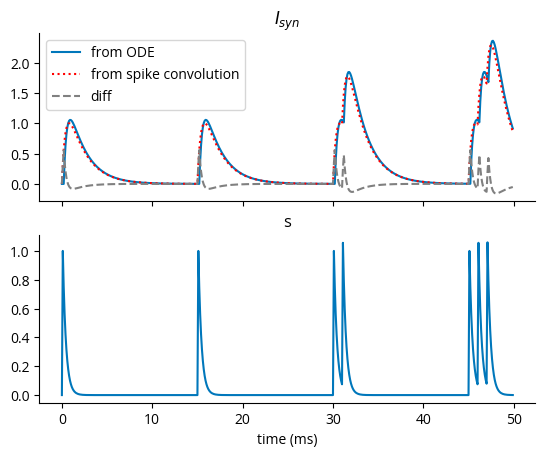

In [31]:
b2.prefs.codegen.target = "numpy"
ng = b2.NeuronGroup(
    1,
    """dv/dt = (I_syn - v)/ms : 1
    I_syn : 1""",
)
t_spk = [0, 15, 30, 31, 45, 46, 47] * b2.ms
sgg = b2.SpikeGeneratorGroup(
    1,
    np.zeros(len(t_spk)),
    t_spk,
)
tau1 = 2 * b2.ms
tau2 = 0.4 * b2.ms
invpeak = (tau2 / tau1) ** (tau1 / (tau2 - tau1))
tau_rise = tau1 * tau2 / (tau1 - tau2)

syn = b2.Synapses(
    sgg,
    ng,
    """dI_syn_syn/dt = (invpeak*s - I_syn)/tau1 : 1
    I_syn_post = I_syn_syn : 1 (summed)
    ds/dt = -s/tau2 : 1""",
    on_pre="s += 1",
)
syn.connect(i=0, j=0)
syn_mon = b2.StateMonitor(syn, ["I_syn", "s"], record=True)
net = b2.Network(ng, sgg, syn, syn_mon)
net.run(50 * b2.ms)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(syn_mon.t / b2.ms, syn_mon.I_syn[0], label="from ODE")

t_conv = np.array(syn_mon.t) * b2.second
t_spk_conv = t_conv[..., None] - t_spk
B = 1 / ((tau2 / tau1) ** (tau_rise / tau1) - (tau2 / tau1) ** (tau_rise / tau2))
I_syn_conv = (
    B * (np.exp(-t_spk_conv / tau1) - np.exp(-t_spk_conv / tau2)) * (t_spk_conv >= 0)
)
I_syn_conv = np.nan_to_num(I_syn_conv)
I_syn_conv = I_syn_conv.sum(axis=1)
# I_syn_conv = I_syn_conv / I_syn_conv.max() * syn_mon.I_syn[0].max()
ax1.plot(
    syn_mon.t / b2.ms, I_syn_conv, linestyle=":", c="r", label="from spike convolution"
)
ax1.set(title="$I_{syn}$")

ax1.plot(
    syn_mon.t / b2.ms,
    I_syn_conv - syn_mon.I_syn[0],
    linestyle="--",
    c="gray",
    label="diff",
)
ax1.legend()

ax2.plot(syn_mon.t / b2.ms, syn_mon.s[0])
ax2.set(title="s", xlabel="time (ms)")

The two solutions aren't identical, possibly due to inexact integration and/or update schedules.

In [25]:
np.allclose(I_syn_conv, syn_mon.I_syn[0].T)

False